# Recreating Zwift ride powerplot

## Import .fit file and convert to pandas dataframe

The code for importing .fit files and converting to a pandas dataframe is from http://johannesjacob.com/analyze-your-cycling-data-python/.
To install the python packages, type 'pip install pandas numpy fitparse matplotlib tqdm' on the command line.


In [1]:
import os
import datetime
from fitparse import FitFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
filename = input("Type filename, including .fit extension:  ")
# 2021-10-05-10-54-32.fit

fitfile = FitFile(filename)

Type filename, including .fit extension:  2021-10-05-10-54-32.fit


From Johannes Jacob's blog post:  
_"Now we are ready to import the workout file and transform the data into a 
pandas dataframe. Unfortunately we have to use an ugly hack with this "while" 
loop to avoid timing issues. Then we are looping through the file, append 
the records to a list and convert the list to a pandas dataframe."_

In [3]:
while True:
    try:
        fitfile.messages
        break
    except KeyError:
        continue
workout = []
for record in fitfile.get_messages('record'):
    r = {}
    for record_data in record:
        r[record_data.name] = record_data.value
    workout.append(r)
df = pd.DataFrame(workout)

In [4]:
df

,altitude,cadence,compressed_speed_distance,cycle_length,distance,enhanced_altitude,enhanced_speed,grade,heart_rate,position_lat,position_long,power,resistance,speed,temperature,time_from_course,timestamp
0,5.0,108,None,None,None,5.0,9.948,None,165,-138819701,1991832102,280,None,9.948,None,None,2021-10-05 18:05:18
1,5.0,109,None,None,None,5.0,10.150,None,166,-138820063,1991831076,248,None,10.150,None,None,2021-10-05 18:05:19
2,5.0,110,None,None,None,5.0,10.311,None,167,-138820372,1991830018,245,None,10.311,None,None,2021-10-05 18:05:20
3,5.0,108,None,None,None,5.0,10.464,None,168,-138820865,1991828979,248,None,10.464,None,None,2021-10-05 18:05:21
4,4.8,107,None,None,None,4.8,10.771,None,168,-138821057,1991827881,234,None,10.771,None,None,2021-10-05 18:05:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4671,-5.4,0,None,None,None,-5.4,1.061,None,143,-138956810,1991928451,0,None,1.061,None,None,2021-10-05 19:23:09
4672,-5.4,0,None,None,None,-5.4,0.330,None,142,-138956881,1991928423,0,None,0.330,None,None,2021-10-05 19:23:10
4673,-5.4,0,None,None,None,-5.4,0.000,None,142,-138956889,1991928420,0,None,0.000,None,None,2021-10-05 19:23:11
4674,-5.4,0,None,None,None,-5.4,0.000,None,141,-138956888,1991928421,0,None,0.000,None,None,2021-10-05 19:23:12


In [5]:
df.tail(1)

,altitude,cadence,compressed_speed_distance,cycle_length,distance,enhanced_altitude,enhanced_speed,grade,heart_rate,position_lat,position_long,power,resistance,speed,temperature,time_from_course,timestamp
4675,-5.4,0,None,None,None,-5.4,0.0,None,141,-138956888,1991928421,0,None,0.0,None,None,2021-10-05 19:23:13


## Get date of workout from column 'timestamp' 

In [6]:
timestamp = df['timestamp'].tail(1).values
timestamp

array(['2021-10-05T19:23:13.000000000'], dtype='datetime64[ns]')

In [7]:
date = np.datetime_as_string(timestamp, unit='D')
date

array(['2021-10-05'], dtype='<U28')

In [8]:
date_str = str(date)
type(date_str)
print(date_str)


['2021-10-05']


In [9]:
date_str = date_str.strip("[")
date_str = date_str.strip("]")
date_str = date_str.strip("'")
print(date_str)

2021-10-05


##  Remove unnecessary columns

In [10]:
df.columns

Index(['altitude', 'cadence', 'compressed_speed_distance', 'cycle_length',
       'distance', 'enhanced_altitude', 'enhanced_speed', 'grade',
       'heart_rate', 'position_lat', 'position_long', 'power', 'resistance',
       'speed', 'temperature', 'time_from_course', 'timestamp'],
      dtype='object')

I'd like to keep the following columns only:
* cadence
* heart_rate
* power
* speed


In [11]:
df_subset = pd.DataFrame(df, columns=['cadence', 'heart_rate', 'power', 'speed'])
df_subset

,cadence,heart_rate,power,speed
0,108,165,280,9.948
1,109,166,248,10.150
2,110,167,245,10.311
3,108,168,248,10.464
4,107,168,234,10.771
...,...,...,...,...
4671,0,143,0,1.061
4672,0,142,0,0.330
4673,0,142,0,0.000
4674,0,141,0,0.000


In [12]:
df_subset['power'].isna().value_counts()

False    4676
Name: power, dtype: int64

In [13]:
len(df_subset)

4676

##  Insert a column 'time_unit' 

_**Note:  Zwift records workout data once every second.  Using .fit files with data recorded more or less frequently will result in an incorrect number of minutes on the x-axis of the graph.**_

In [14]:
df_subset.insert(loc=0, column='time_unit', value=np.arange(len(df_subset)))

In [15]:
df_subset

,time_unit,cadence,heart_rate,power,speed
0,0,108,165,280,9.948
1,1,109,166,248,10.150
2,2,110,167,245,10.311
3,3,108,168,248,10.464
4,4,107,168,234,10.771
...,...,...,...,...,...
4671,4671,0,143,0,1.061
4672,4672,0,142,0,0.330
4673,4673,0,142,0,0.000
4674,4674,0,141,0,0.000


In [16]:
df_subset.rename(columns = {'power':'watts'}, inplace = True)

In [17]:
df_subset

,time_unit,cadence,heart_rate,watts,speed
0,0,108,165,280,9.948
1,1,109,166,248,10.150
2,2,110,167,245,10.311
3,3,108,168,248,10.464
4,4,107,168,234,10.771
...,...,...,...,...,...
4671,4671,0,143,0,1.061
4672,4672,0,142,0,0.330
4673,4673,0,142,0,0.000
4674,4674,0,141,0,0.000


In [18]:
df_subset['watts'].max()

294

##  Obtain FTP value from user to determine workout zones in graph

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from smooth import smooth

In [21]:
ftp = None

# set up try / except loop:

n = 0
while n < 3: 
    try:
        ftp = int(input("Enter FTP in watts (whole numbers only):  "))
        print(f"\nYour FTP has been recorded as {ftp} watts.")
        break
    except ValueError:
        n += 1
        print("\nYour FTP value cannot contain letters, be left blank, or be entered as a decimal value. \n")


Enter FTP in watts (whole numbers only):  120

Your FTP has been recorded as 120 watts.


In [22]:
type(ftp)

int

In [23]:
print(ftp)

120


In [24]:
# convert df to numpy array

workout_data = df_subset.to_records(index=False)

In [25]:
workout_data

rec.array([(   0, 108, 165, 280,  9.948), (   1, 109, 166, 248, 10.15 ),
           (   2, 110, 167, 245, 10.311), ...,
           (4673,   0, 142,   0,  0.   ), (4674,   0, 141,   0,  0.   ),
           (4675,   0, 141,   0,  0.   )],
          dtype=[('time_unit', '<i8'), ('cadence', '<i8'), ('heart_rate', '<i8'), ('watts', '<i8'), ('speed', '<f8')])

In [26]:
watts = workout_data['watts']
time = workout_data['time_unit']

In [27]:
watts.max()

294

In [28]:
max_watts = max(watts)
max_watts

294

In [29]:
y_top = max(watts)*1.20
y_top

352.8

In [30]:
len(time)

4676

In [31]:
watts_smoothed = smooth(watts, window_len=25)
print(len(watts_smoothed))
watts_smoothed

4676


array([2.74581852e+02, 2.63853559e+02, 2.53436234e+02, ...,
       2.45651647e-01, 4.11729599e-02, 0.00000000e+00])

##  Give user the opportunity to enter how often .fit file data is recorded, in seconds (default is once per second, as on Zwift)

In [32]:
# Workout .fit file recorded by Zwift?

zwift_or_not = input("Was your .fit file recorded by Zwift, and/or did you device record the workout in 1-second increments?  \nEnter 'y' for yes or 'n' for no. ")

Was your .fit file recorded by Zwift, and/or did you device record the workout in 1-second increments?  
Enter 'y' for yes or 'n' for no. y


In [33]:
zwift_or_not

'y'

In [34]:
if zwift_or_not=='y' or zwift_or_not=='':
    rec_freq = 1
    print(f"\nThe default recording frequency has been set to {rec_freq} second.")

    
# If .fit file not recorded by Zwift, how frequently was data recorded, in seconds?

if zwift_or_not=='n':
    # default recording frequency to start with:
    rec_freq = 1
    
    # set up try / except loop:
    n = 0
    while n < 3: 
        try:
            rec_freq = int(input("Please enter the frequency that your workout data was recorded, in seconds.  \nEntry must be in numbers >0 and <=60, e.g., '1' for once per second, '5' to represent data recorded once every 5 seconds, '10' to signify once every 10 seconds, etc.   "))
            print(f"\nThe recording frequency has been set to {rec_freq} second(s).")
            break
        except ValueError:
            n += 1
            print()
        if n == 3:
            print(f"\nThe recording frequency has been set to {rec_freq} second(s).")



The default recording frequency has been set to 1 second.


In [35]:
rec_freq

1

##  Convert workout x-axis time values to minutes

In [36]:
# converting recording data into minutes  
# freq represents how many rows of data are contained in 1 minute of workout time
# For example, if data is recorded every 5 seconds, then there will be 12 rows of data 
# per every one minute of workout time

freq = 60 / rec_freq
freq


60.0

In [37]:
minutes = workout_data['time_unit']/freq
print(minutes)

[0.00000000e+00 1.66666667e-02 3.33333333e-02 ... 7.78833333e+01
 7.79000000e+01 7.79166667e+01]


## Allow user to upload image and enter name if desired, then draw graph

If you wish to upload a thumbnail image in the upper right hand corner of the graph, please enter the name of it here:  example_image.png
Your name? Gina Durante


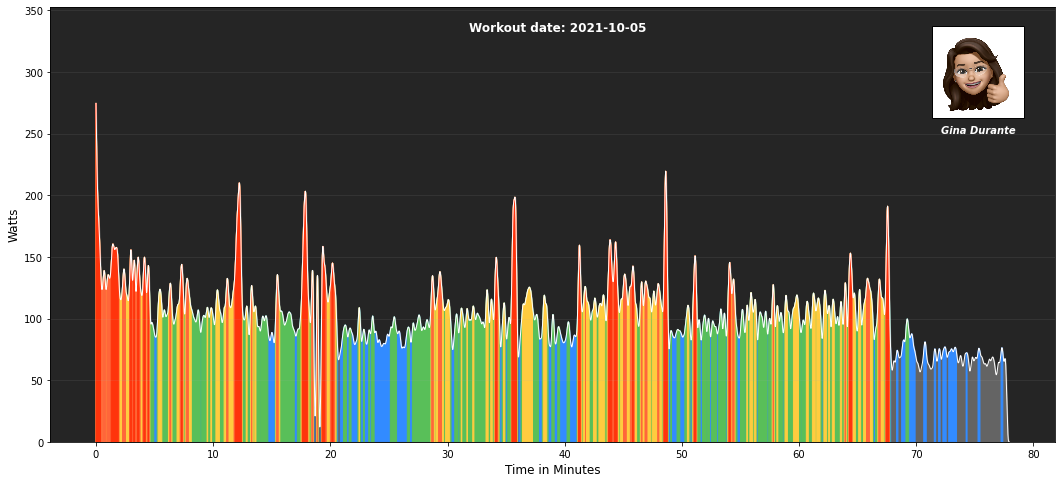

In [60]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.text import Annotation


if ftp != None:
    img, ax = plt.subplots(figsize=(18, 8))
    ax.set_facecolor(color='#252525')
    ax.set_xlabel("Time in Minutes", fontsize='large')
    ax.set_ylabel("Watts", fontsize='large')

    # This expands the top of the graph to 20% beyond max watts
    ax.set_ylim(top=max(watts)*1.20)

    # logic for color under the graph based on % of FTP (thanks to Jonas Häggqvist for this code)
    ax.grid(which='major', axis='y', alpha=0.1, linewidth=1)
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 0.00*ftp, color='#646464')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 0.60*ftp, color='#328bff')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 0.75*ftp, color='#59bf59')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 0.90*ftp, color='#ffcc3f')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 1.05*ftp, color='#ff663a')
    plt.fill_between(minutes, watts_smoothed, where=watts_smoothed > 1.18*ftp, color='#ff340c')

    # Setting the image and location (thanks to Phil Daws for the code that helped me get started)

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xy = [xmax-(xmax*0.08), ymax-(ymax*0.15)]
    
    # Adding the workout date to the graph
    workout_date = Annotation(f'Workout date: {date_str}', xy=[xmax-50, ymax-20], color='white', 
                              fontweight='bold', fontsize='large')
    ax.add_artist(workout_date)

    # Upload image, e.g., "example_image.png"
    img_name = input("If you wish to upload a thumbnail image in the upper right hand corner of the graph, please enter the name of it here:  ")
    if img_name != '':
        img = plt.imread(img_name, format=None)
        imagebox = OffsetImage(img, zoom=0.2)
        imagebox.image.axes = ax

        ab = AnnotationBbox(imagebox, xy, frameon=True)
        ax.add_artist(ab)

        # Adding name under image
        name = input("Your name? ")
        rider_name = Annotation(name, xy=[xmax-(xmax*0.08), ymax-(ymax*0.29)], xycoords='data', 
                                ha='center', color='white', fontweight='bold', fontsize='medium', 
                                fontstyle='italic')

        ax.add_artist(rider_name)

    # Setting plot line color and thickness
    plt.plot(minutes, watts_smoothed, color='white', linewidth=1.0)

    plt.show()

else:
    print(f"\nThe graph cannot be drawn; no valid FTP was provided.")
    print(f"If you wish to try again, please have your FTP value ready and then reload this page.")
